<a href="https://colab.research.google.com/github/AishlyManglani/Deep-Learning_-CMPE258/blob/main/computer%20vision/supervised_contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q tensorflow
!pip install -q tensorflow-addons

In [5]:
!pip install -q umap-learn

In [8]:
!pip install --upgrade tensorflow-addons

In [12]:

!pip install -q tensorflow==2.15.0 keras==2.15.0 tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
ten

In [1]:

# 1. Install + Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:

# 2. Load CIFAR-10 dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
y_train = y_train.flatten()
y_test = y_test.flatten()
NUM_CLASSES = 10

170498071/170498071 [==============================] - 3s 0us/step


In [3]:

# 3. Define a Simple CNN Backbone

def create_backbone():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs, x, name="backbone")

In [4]:

# 4. Define two models

def create_softmax_model():
    backbone = create_backbone()
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(backbone.output)
    model = tf.keras.Model(backbone.input, outputs)
    return model

def create_contrastive_model():
    backbone = create_backbone()
    projection = tf.keras.layers.Dense(128)(backbone.output)  # Linear projection head
    model = tf.keras.Model(backbone.input, projection)
    return model

In [5]:

# 5. Define losses

crossentropy_loss = tf.keras.losses.SparseCategoricalCrossentropy()

contrastive_loss = tfa.losses.ContrastiveLoss()

def supervised_contrastive_loss(features, labels, temperature=0.1):
    labels = tf.reshape(labels, [-1, 1])
    features = tf.math.l2_normalize(features, axis=1)
    logits = tf.matmul(features, features, transpose_b=True) / temperature
    labels = tf.cast(tf.equal(labels, tf.transpose(labels)), tf.float32)
    loss = tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

In [6]:

# 6. Train regular softmax model

softmax_model = create_softmax_model()
softmax_model.compile(optimizer='adam', loss=crossentropy_loss, metrics=['accuracy'])

history_softmax = softmax_model.fit(
    x_train, y_train, epochs=20, batch_size=128,
    validation_data=(x_test, y_test)
)

Epoch 1/20
391/391 [==============================] - 119s 301ms/step - loss: 1.8854 - accuracy: 0.2765 - val_loss: 1.6881 - val_accuracy: 0.3520
Epoch 2/20
391/391 [==============================] - 122s 313ms/step - loss: 1.6595 - accuracy: 0.3692 - val_loss: 1.6119 - val_accuracy: 0.4010
Epoch 3/20
391/391 [==============================] - 115s 294ms/step - loss: 1.5784 - accuracy: 0.4157 - val_loss: 1.5089 - val_accuracy: 0.4450
Epoch 4/20
391/391 [==============================] - 121s 311ms/step - loss: 1.4968 - accuracy: 0.4491 - val_loss: 1.4637 - val_accuracy: 0.4662
Epoch 5/20
391/391 [==============================] - 121s 308ms/step - loss: 1.4374 - accuracy: 0.4771 - val_loss: 1.3881 - val_accuracy: 0.4946
Epoch 6/20
391/391 [==============================] - 121s 310ms/step - loss: 1.3880 - accuracy: 0.4987 - val_loss: 1.3655 - val_accuracy: 0.5088
Epoch 7/20
391/391 [==============================] - 119s 305ms/step - loss: 1.3538 - accuracy: 0.5120 - val_loss: 1.3910 -

In [8]:

# 7. Train contrastive model

contrastive_model = create_contrastive_model()
optimizer = tf.keras.optimizers.Adam()

BATCH_SIZE = 128
EPOCHS = 10

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    epoch_loss = []
    for images, labels in train_dataset:
        with tf.GradientTape() as tape:
            features = contrastive_model(images, training=True)
            loss = supervised_contrastive_loss(features, labels)
        grads = tape.gradient(loss, contrastive_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, contrastive_model.trainable_variables))
        epoch_loss.append(loss.numpy())

    train_losses.append(np.mean(epoch_loss))

    # Evaluate using a linear classifier
    features_train = contrastive_model.predict(x_train, batch_size=256)
    features_test = contrastive_model.predict(x_test, batch_size=256)

    clf = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128,)),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    clf.fit(features_train, y_train, epochs=5, verbose=0, batch_size=256)
    test_acc = clf.evaluate(features_test, y_test, verbose=0)[1]
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}: Contrastive Train Loss={np.mean(epoch_loss):.4f} | Test Accuracy={test_acc:.4f}")



40/40 [==============================] - 6s 146ms/step
Epoch 1: Contrastive Train Loss=66.4891 | Test Accuracy=0.1340
40/40 [==============================] - 7s 169ms/step
Epoch 2: Contrastive Train Loss=66.4719 | Test Accuracy=0.1120
40/40 [==============================] - 7s 171ms/step
Epoch 3: Contrastive Train Loss=66.2111 | Test Accuracy=0.1474
40/40 [==============================] - 7s 163ms/step
Epoch 4: Contrastive Train Loss=66.2740 | Test Accuracy=0.1100
40/40 [==============================] - 6s 139ms/step
Epoch 5: Contrastive Train Loss=66.4499 | Test Accuracy=0.1003
40/40 [==============================] - 6s 156ms/step
Epoch 6: Contrastive Train Loss=66.4870 | Test Accuracy=0.1005
40/40 [==============================] - 6s 158ms/step
Epoch 7: Contrastive Train Loss=66.4310 | Test Accuracy=0.1000
40/40 [==============================] - 6s 151ms/step
Epoch 8: Contrastive Train Loss=66.3224 | Test Accuracy=0.1000
40/40 [==============================] - 5s 132ms/step
E

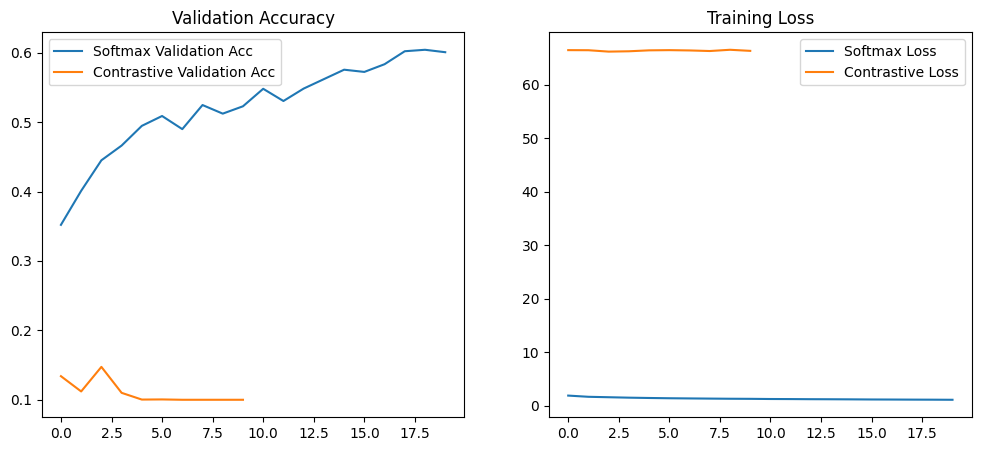

40/40 [==============================] - 6s 153ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


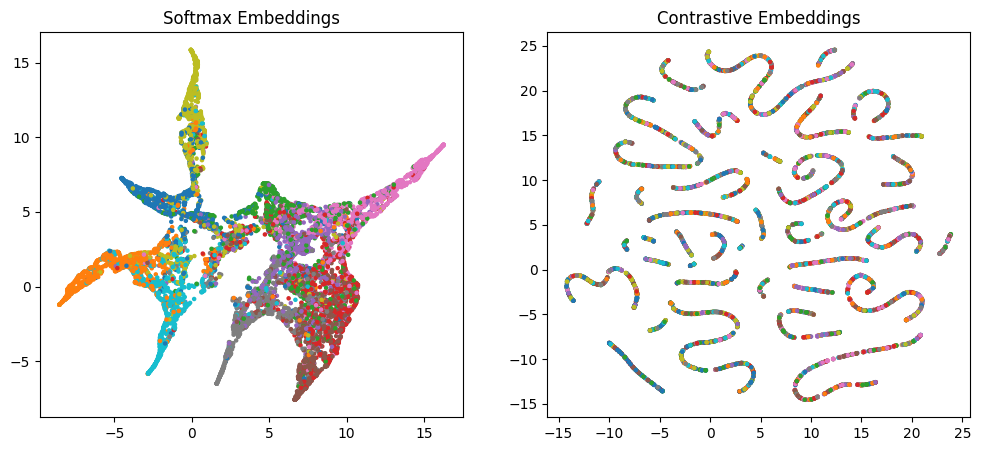

313/313 [==============================] - 0s 1ms/step


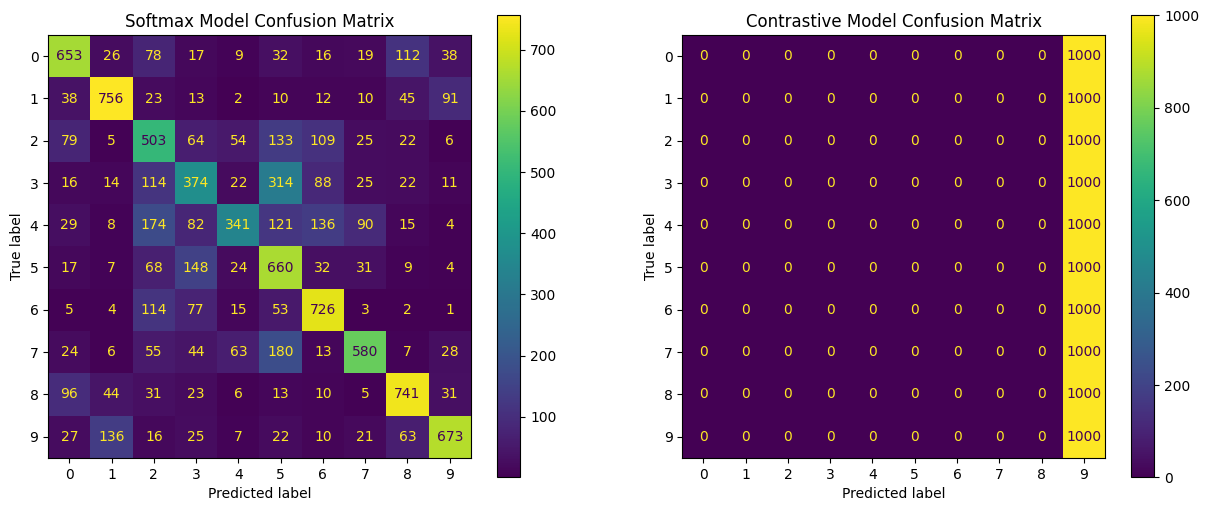

In [9]:

# 8. Visualizations

# (A) Training Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_softmax.history['val_accuracy'], label='Softmax Validation Acc')
plt.plot(test_accuracies, label='Contrastive Validation Acc')
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_softmax.history['loss'], label='Softmax Loss')
plt.plot(train_losses, label='Contrastive Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

# (B) Embedding Visualization with UMAP
features_softmax = softmax_model.predict(x_test, batch_size=256)
features_contrastive = contrastive_model.predict(x_test, batch_size=256)

umap_reducer = umap.UMAP()

embed_softmax = umap_reducer.fit_transform(features_softmax)
embed_contrastive = umap_reducer.fit_transform(features_contrastive)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(embed_softmax[:,0], embed_softmax[:,1], c=y_test, cmap='tab10', s=5)
plt.title("Softmax Embeddings")

plt.subplot(1,2,2)
plt.scatter(embed_contrastive[:,0], embed_contrastive[:,1], c=y_test, cmap='tab10', s=5)
plt.title("Contrastive Embeddings")
plt.show()

# (C) Confusion Matrix
y_pred_softmax = np.argmax(softmax_model.predict(x_test), axis=1)
features_test = contrastive_model.predict(x_test)
features_train = contrastive_model.predict(x_train)

# Train a final linear probe for contrastive features
final_clf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
final_clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_clf.fit(features_train, y_train, epochs=5, verbose=0)
y_pred_contrastive = np.argmax(final_clf.predict(features_test), axis=1)

cm_softmax = confusion_matrix(y_test, y_pred_softmax)
cm_contrastive = confusion_matrix(y_test, y_pred_contrastive)

fig, axes = plt.subplots(1,2, figsize=(15,6))
ConfusionMatrixDisplay(cm_softmax).plot(ax=axes[0])
axes[0].set_title("Softmax Model Confusion Matrix")

ConfusionMatrixDisplay(cm_contrastive).plot(ax=axes[1])
axes[1].set_title("Contrastive Model Confusion Matrix")
plt.show()
